## Lab5

### import all needed libraries

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

### load images

In [2]:
bike_l = cv.imread('bike_l.png')
bike_r = cv.imread('bike_r.png')
coaster_l = cv.imread('coaster_left.jpg')
coaster_r = cv.imread('coaster_right.jpg')
tape_l = cv.imread('tape_l.jpg')
tape_r = cv.imread('tape_r.jpg')

bike_l_gray = cv.cvtColor(bike_l,cv.COLOR_BGR2GRAY)
bike_r_gray = cv.cvtColor(bike_r,cv.COLOR_BGR2GRAY)
coaster_l_gray = cv.cvtColor(coaster_l,cv.COLOR_BGR2GRAY)
coaster_r_gray = cv.cvtColor(coaster_r,cv.COLOR_BGR2GRAY)
tape_l_gray = cv.cvtColor(tape_l,cv.COLOR_BGR2GRAY)
tape_r_gray = cv.cvtColor(tape_r,cv.COLOR_BGR2GRAY)

### 1.1 Fundamental Matrix Calculation

In [3]:
# SIFT
my_SIFT_instance = cv.SIFT_create()
mask = None

[kps_bike_l,dps_bike_l] = my_SIFT_instance.detectAndCompute(bike_l_gray,mask)
[kps_bike_r,dps_bike_r] = my_SIFT_instance.detectAndCompute(bike_r_gray,mask)
[kps_coaster_l,dps_coaster_l] = my_SIFT_instance.detectAndCompute(coaster_l_gray,mask)
[kps_coaster_r,dps_coaster_r] = my_SIFT_instance.detectAndCompute(coaster_r_gray,mask)
[kps_tape_l,dps_tape_l] = my_SIFT_instance.detectAndCompute(tape_l_gray,mask)
[kps_tape_r,dps_tape_r] = my_SIFT_instance.detectAndCompute(tape_r_gray,mask)

# Matcher
bf = cv.FlannBasedMatcher(dict(algorithm = 0, trees = 5), dict(checks = 50) )
bike_matches = bf.knnMatch(dps_bike_l,dps_bike_r, k=2)
coaster_matches = bf.knnMatch(dps_coaster_l,dps_coaster_r, k=2)
tape_matches = bf.knnMatch(dps_tape_l,dps_tape_r, k=2)
match = cv.drawMatchesKnn(bike_l_gray, kps_bike_l, bike_r_gray, kps_bike_r, bike_matches, None, flags=0)

# Lowe's Ratio's matches
def LoweRatioTest(match):  
    good_distance = []
    distance = []
    ratio_match = []
    query = []
    train = []
    for m,n in match:
        distance.append(m.distance)
        ratio = (m.distance)/(n.distance)
        if ratio < 0.7:
            ratio_match.append([m])
            query.append(m.queryIdx)
            good_distance.append(m.distance)
            train.append(m.trainIdx)
    return ratio_match,good_distance,distance,query,train

def FundamentalMatrixCalculationBike(pic1, pic2):
    _,_,_,p1,p2 = LoweRatioTest(bike_matches)
    p1 = np.int32([kps_bike_l[m].pt for m in p1])
    p2 = np.int32([kps_bike_r[m].pt for m in p2])
    Fundamental, mask = cv.findFundamentalMat(p1, p2, cv.FM_LMEDS)
    return Fundamental, p1.flatten(), p2.flatten()

def FundamentalMatrixCalculationCoaster(pic1, pic2):
    p1 = []
    p2 = []
    _,_,_,p1,p2 = LoweRatioTest(coaster_matches)
    p1 = np.int32([kps_coaster_l[m].pt for m in p1])
    p2 = np.int32([kps_coaster_r[m].pt for m in p2])
    Fundamental, mask = cv.findFundamentalMat(p1, p2, cv.FM_LMEDS)
    return Fundamental, p1.flatten(), p2.flatten()

def FundamentalMatrixCalculationTape(pic1, pic2):
    p1 = []
    p2 = []
    _,_,_,p1,p2 = LoweRatioTest(tape_matches)
    p1 = np.int32([kps_tape_l[m].pt for m in p1])
    p2 = np.int32([kps_tape_r[m].pt for m in p2])
    Fundamental, mask = cv.findFundamentalMat(p1, p2, cv.FM_LMEDS)
    return Fundamental, p1.flatten(), p2.flatten()

### 1.2 Image Rectification

<Figure size 1800x1200 with 0 Axes>

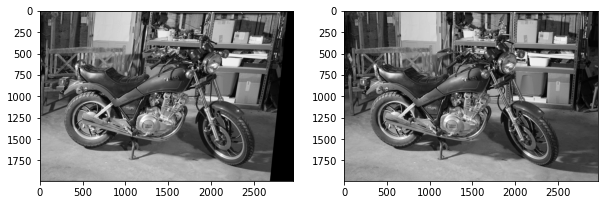

In [4]:
def ImageRectificationBike(pic1, pic2):
    output = []
    size = [pic1.shape[0], pic1.shape[1]]
    rectified = [pic1.shape[1], pic1.shape[0]]
    Fundamental, p1, p2 = FundamentalMatrixCalculationBike(pic1, pic2)
    _, homography1, homography2 = cv.stereoRectifyUncalibrated(p1, p2, Fundamental, size, threshold = 10)
    result1 = cv.warpPerspective(cv.cvtColor(pic1, cv.COLOR_BGR2GRAY), homography1, rectified, borderValue = (0,0,0))
    result2 = cv.warpPerspective(cv.cvtColor(pic2, cv.COLOR_BGR2GRAY), homography2, rectified, borderValue = (0,0,0))
    return result1, result2 

def ImageRectificationCoaster(pic1, pic2):
    output = []
    size = [pic1.shape[0], pic1.shape[1]]
    rectified = [pic1.shape[1], pic1.shape[0]]
    Fundamental, p1, p2 = FundamentalMatrixCalculationCoaster(pic1, pic2)
    _, homography1, homography2 = cv.stereoRectifyUncalibrated(p1, p2, Fundamental, size, threshold = 10)
    result1 = cv.warpPerspective(cv.cvtColor(pic1, cv.COLOR_BGR2GRAY), homography1, rectified, borderValue = (0,0,0))
    result2 = cv.warpPerspective(cv.cvtColor(pic2, cv.COLOR_BGR2GRAY), homography2, rectified, borderValue = (0,0,0))
    return result1, result2 

def ImageRectificationTape(pic1, pic2):
    output = []
    size = [pic1.shape[0], pic1.shape[1]]
    rectified = [pic1.shape[1], pic1.shape[0]]
    Fundamental, p1, p2 = FundamentalMatrixCalculationTape(pic1, pic2)
    _, homography1, homography2 = cv.stereoRectifyUncalibrated(p1, p2, Fundamental, size)
    result1 = cv.warpPerspective(cv.cvtColor(pic1, cv.COLOR_BGR2GRAY), homography1, rectified, borderValue = (0,0,0))
    result2 = cv.warpPerspective(cv.cvtColor(pic2, cv.COLOR_BGR2GRAY), homography2, rectified, borderValue = (0,0,0))
    return result1, result2 

bike_rec_l, bike_rec_r  = ImageRectificationBike(bike_l, bike_r)
plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(bike_rec_l, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(bike_rec_r, cmap="gray")

<Figure size 1800x1200 with 0 Axes>

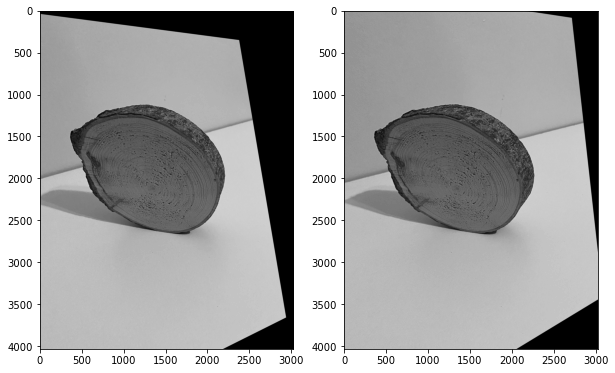

In [5]:
coaster_rec_l, coaster_rec_r  = ImageRectificationCoaster(coaster_l, coaster_r)
plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(coaster_rec_l, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(coaster_rec_r, cmap="gray")

<Figure size 1800x1200 with 0 Axes>

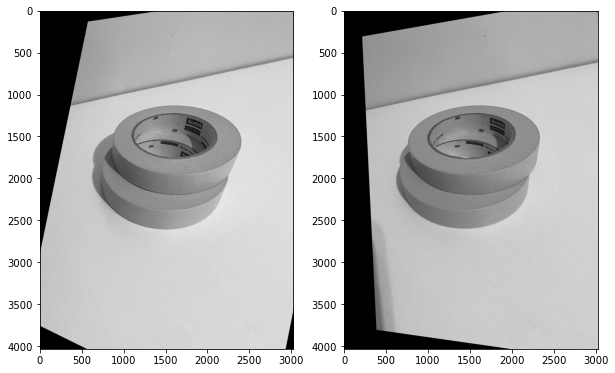

In [6]:
tape_rec_l, tape_rec_r  = ImageRectificationTape(tape_l, tape_r)
plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(tape_rec_l, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(tape_rec_r, cmap="gray")

### 1.3 Block Matching Disparity Map Calculation 

In [7]:
def BlockMatchingDisparityMapCalculation(refl,refr,dispar, size):
    my_stereo_instance = cv.StereoBM_create(numDisparities = dispar*16, blockSize = size)
    output = my_stereo_instance.compute(refl, refr)
    plt.figure(dpi=300)
    plt.figure(figsize=(10,10))
    plt.imshow(output, cmap="gray")

#### Bike: numDisparities value = 128; blockSize value = 15

<Figure size 1800x1200 with 0 Axes>

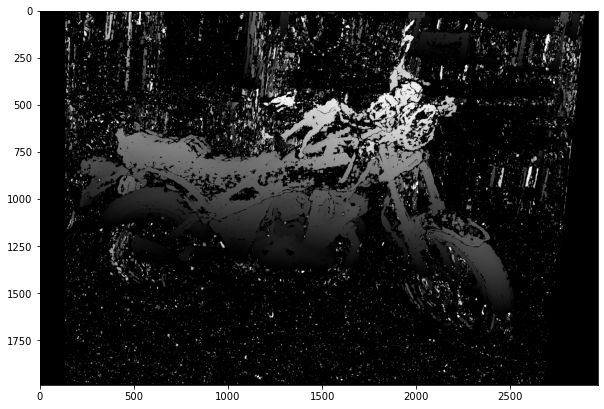

In [8]:
BlockMatchingDisparityMapCalculation(bike_rec_l, bike_rec_r, 8, 15)

#### Coaster: numDisparities value = 64; blockSize value = 5

<Figure size 1800x1200 with 0 Axes>

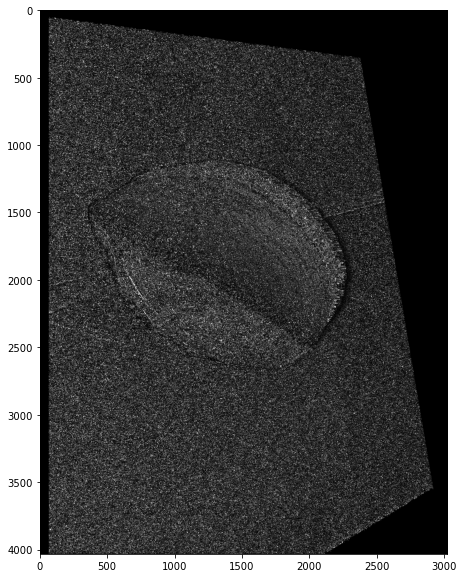

In [9]:
BlockMatchingDisparityMapCalculation(coaster_rec_l, coaster_rec_r, 4, 5)

#### Tape: numDisparities value = 64; blockSize value = 5

<Figure size 1800x1200 with 0 Axes>

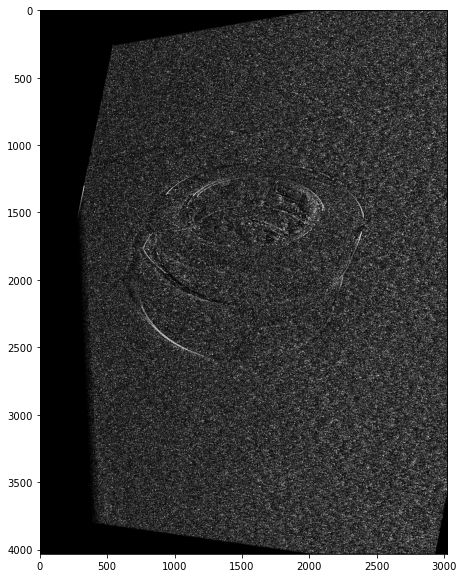

In [10]:
BlockMatchingDisparityMapCalculation(tape_rec_l, tape_rec_r, 4, 5)